In [6]:
import matplotlib.pyplot as plt
import json
from pathlib import Path
import pandas as pd
import numpy as np


# Training Dynamics Analysis

**Purpose:** This notebook analyzes the training behavior of different models on the Tiny ImageNet-200 dataset, examining learning curves, overfitting patterns, and convergence characteristics.

**Key Analyses:**
- Validation accuracy progression across models
- Training vs validation accuracy gaps (overfitting analysis)
- Learning dynamics and convergence patterns

In [7]:
def load_model_results(results_dir="../results"):
    """Load all model results from JSON files"""
    results_path = Path(results_dir)
    models_data = {}
    
    for model_dir in results_path.iterdir():
        if model_dir.is_dir() and not model_dir.name.startswith('.'):
            model_name = model_dir.name
            
            # Load test results
            test_file = model_dir / "test_results.json"
            history_file = model_dir / "history.json"
            
            if test_file.exists() and history_file.exists():
                with open(test_file, 'r') as f:
                    test_data = json.load(f)
                with open(history_file, 'r') as f:
                    history_data = json.load(f)
                
                models_data[model_name] = {
                    'test': test_data,
                    'history': history_data
                }
    
    return models_data

models_data = load_model_results()
print(f"Loaded {len(models_data)} models: {', '.join(models_data.keys())}")

Loaded 6 models: densenet, resnet, efficientnet, vit, alexnet, vgg


## 1. Validation Accuracy Over Training

The progression of validation accuracy across training epochs for each model. This reveals how quickly models learn, whether they plateau, and which architectures achieve the best final performance.

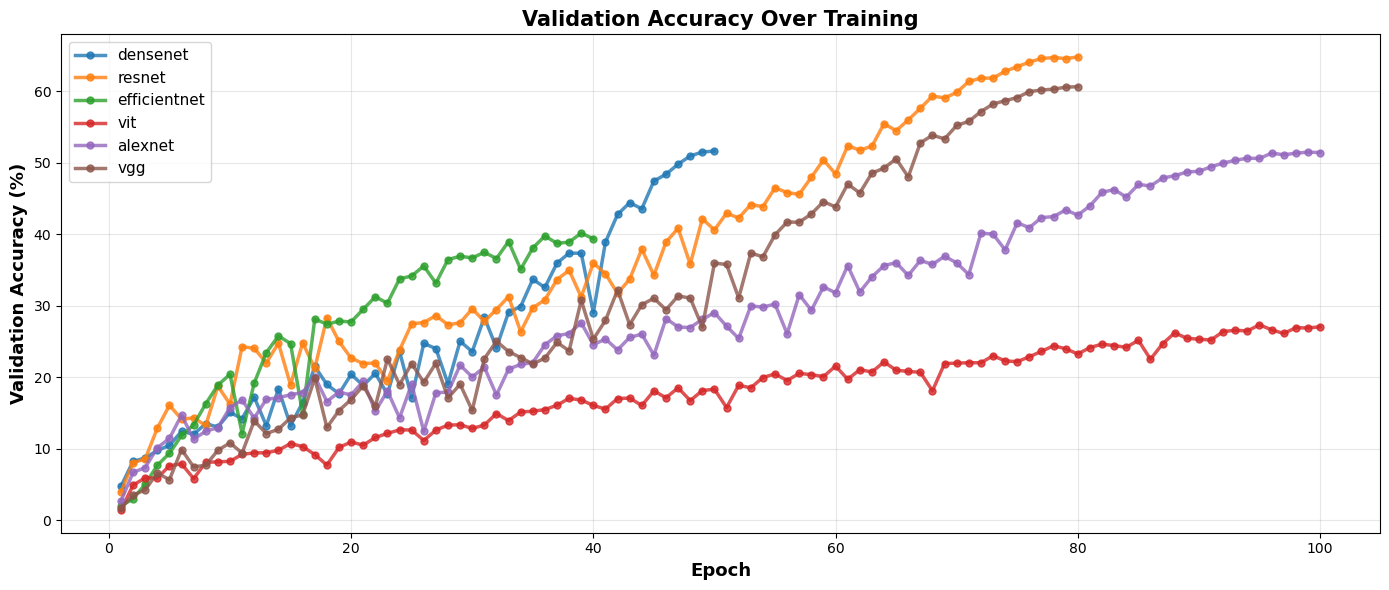

In [8]:
# Validation Accuracy Comparison
plt.figure(figsize=(14, 6))

for model_name, data in models_data.items():
    history = data['history']
    epochs = range(1, len(history['val_acc']) + 1)
    plt.plot(epochs, history['val_acc'], marker='o', label=model_name, 
             linewidth=2.5, markersize=5, alpha=0.8)

plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Validation Accuracy (%)', fontsize=13, fontweight='bold')
plt.title('Validation Accuracy Over Training', fontsize=15, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Overfitting Analysis: Train-Val Gap Over Time

The gap between training and validation accuracy over epochs. A growing gap indicates overfitting, while a negative gap suggests strong regularization. This helps identify which models generalize well vs. those that memorize training data.

In [9]:
# Calculate overfitting metrics for all models
overfitting_data = []

for model_name, data in models_data.items():
    history = data['history']
    
    # Final train-val gap
    final_train_acc = history['train_acc'][-1]
    final_val_acc = history['val_acc'][-1]
    final_gap = final_train_acc - final_val_acc
    
    # Average train-val gap (last 10 epochs)
    recent_gaps = [t - v for t, v in zip(history['train_acc'][-10:], history['val_acc'][-10:])]
    avg_gap = np.mean(recent_gaps)
    
    # Max train-val gap
    all_gaps = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
    max_gap = max(all_gaps)
    
    # Generalization gap (best val - test)
    best_val_acc = max(history['val_acc'])
    test_acc = data['test']['test_acc']
    gen_gap = best_val_acc - test_acc
    
    overfitting_data.append({
        'Model': model_name,
        'Final Train-Val Gap (%)': final_gap,
        'Avg Gap (Last 10) (%)': avg_gap,
        'Max Gap (%)': max_gap,
        'Val-Test Gap (%)': gen_gap,
        'Final Train Acc (%)': final_train_acc,
        'Final Val Acc (%)': final_val_acc,
        'Test Acc (%)': test_acc
    })

overfit_df = pd.DataFrame(overfitting_data)

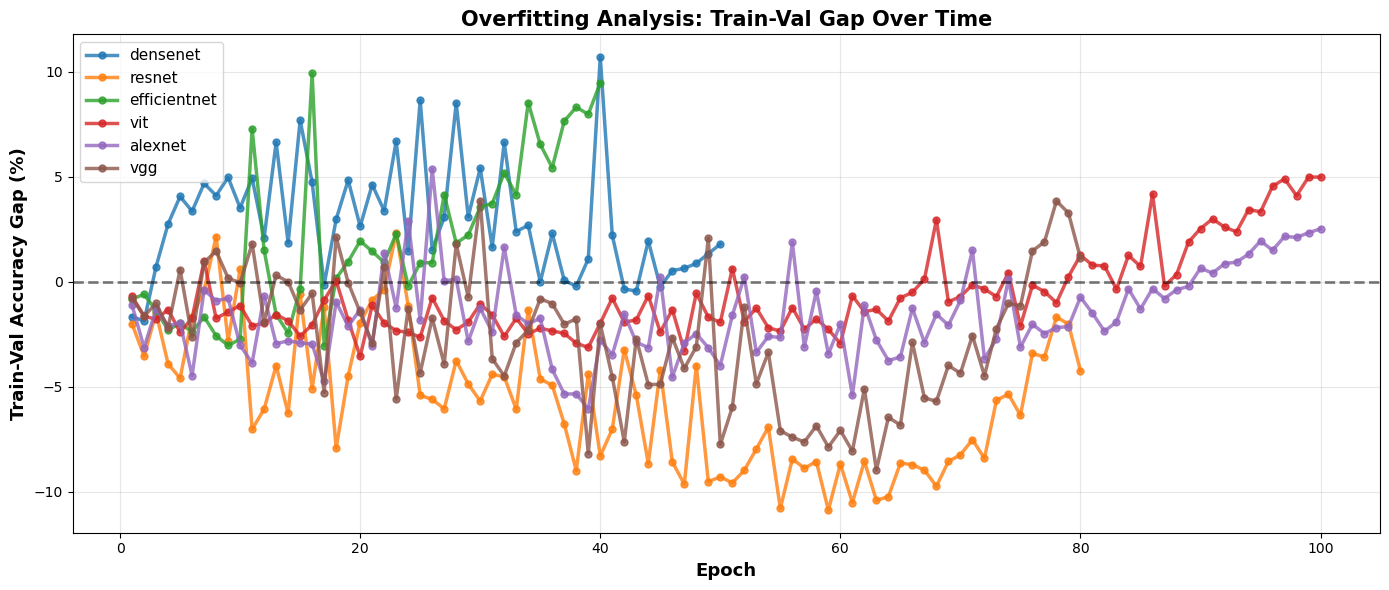

In [10]:
# Train-Val Gap Over Time
plt.figure(figsize=(14, 6))

for model_name, data in models_data.items():
    history = data['history']
    epochs = range(1, len(history['train_acc']) + 1)
    gap = [t - v for t, v in zip(history['train_acc'], history['val_acc'])]
    plt.plot(epochs, gap, marker='o', label=model_name, linewidth=2.5, markersize=5, alpha=0.8)

plt.axhline(y=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
plt.xlabel('Epoch', fontsize=13, fontweight='bold')
plt.ylabel('Train-Val Accuracy Gap (%)', fontsize=13, fontweight='bold')
plt.title('Overfitting Analysis: Train-Val Gap Over Time', fontsize=15, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()